In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set(style="white", color_codes=True)

Can we predict outcome of animal based on:
- animal type
- animal breed (separate model for cats and dogs?)
- age of animal
- baby/adult/senior feature
- sex of animal
- color of animal
- whether or not animal has a name
- month/year of outcome (difference between datetime and monthyear?)

Models:
- Decision tree/Random forest
- Logistic regression? (Lots of dummy variables..)
- SVM

Other considerations:
- Additional models specific to adoption outcomes? To dogs or cats?
- 


In [18]:
raw_data = pd.read_csv('datafiles/aac_shelter_outcomes.csv')
raw_data.head(20)

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,2014-06-15T15:50:00,Monday,Partner,Transfer,Neutered Male
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,2014-07-07T14:04:00,NaN,Rabies Risk,Euthanasia,Unknown
5,4 months,A664462,Dog,Leonberger Mix,Brown/White,2013-06-03T00:00:00,2013-10-07T13:06:00,2013-10-07T13:06:00,*Edgar,Partner,Transfer,Intact Male
6,1 year,A693700,Other,Squirrel Mix,Tan,2013-12-13T00:00:00,2014-12-13T12:20:00,2014-12-13T12:20:00,NaN,Suffering,Euthanasia,Unknown
7,3 years,A692618,Dog,Chihuahua Shorthair Mix,Brown,2011-11-23T00:00:00,2014-12-08T15:55:00,2014-12-08T15:55:00,*Ella,Partner,Transfer,Spayed Female
8,1 month,A685067,Cat,Domestic Shorthair Mix,Blue Tabby/White,2014-06-16T00:00:00,2014-08-14T18:45:00,2014-08-14T18:45:00,Lucy,NaN,Adoption,Intact Female
9,3 months,A678580,Cat,Domestic Shorthair Mix,White/Black,2014-03-26T00:00:00,2014-06-29T17:45:00,2014-06-29T17:45:00,*Frida,Offsite,Adoption,Spayed Female


In [11]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78256 entries, 0 to 78255
Data columns (total 12 columns):
age_upon_outcome    78248 non-null object
animal_id           78256 non-null object
animal_type         78256 non-null object
breed               78256 non-null object
color               78256 non-null object
date_of_birth       78256 non-null object
datetime            78256 non-null object
monthyear           78256 non-null object
name                54370 non-null object
outcome_subtype     35963 non-null object
outcome_type        78244 non-null object
sex_upon_outcome    78254 non-null object
dtypes: object(12)
memory usage: 7.2+ MB


In [12]:
raw_data.nunique()

age_upon_outcome       46
animal_id           70855
animal_type             5
breed                2128
color                 525
date_of_birth        5869
datetime            64361
monthyear           64361
name                14574
outcome_subtype        19
outcome_type            9
sex_upon_outcome        5
dtype: int64

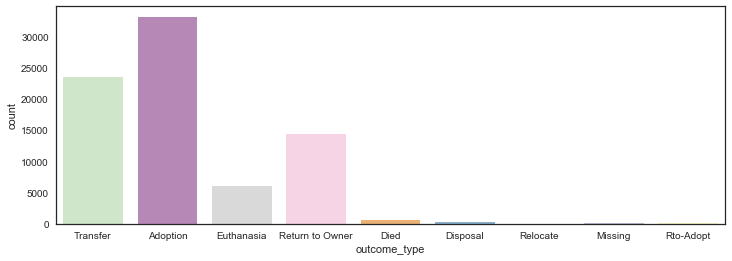

In [78]:
plt.figure(figsize=(12,4))
sns.countplot(x='outcome_type', data=raw_data, palette='Set3_r')

In [7]:
raw_data.groupby(['outcome_type','outcome_subtype']).size()

outcome_type  outcome_subtype    
Adoption      Barn                       1
              Foster                  5558
              Offsite                  367
Died          At Vet                    33
              Enroute                   45
              In Foster                164
              In Kennel                335
              In Surgery                16
Euthanasia    Aggressive               506
              At Vet                    26
              Behavior                 142
              Court/Investigation       18
              Medical                  259
              Rabies Risk             2417
              Suffering               2514
              Underage                  28
Missing       In Foster                 18
              In Kennel                  8
              Possible Theft             9
Transfer      Barn                       2
              Partner                19660
              SCRP                    3211
              Snr   

Not sure what SCRP and Snr means...

In [6]:
raw_data['animal_type'].value_counts()

Dog          44242
Cat          29422
Other         4249
Bird           334
Livestock        9
Name: animal_type, dtype: int64

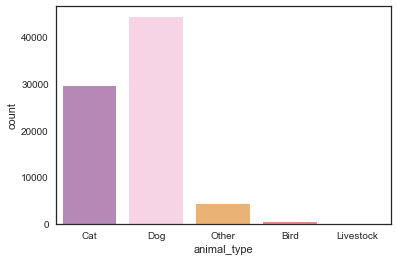

In [70]:
sns.countplot(x='animal_type', data=raw_data, palette='Set3_r')

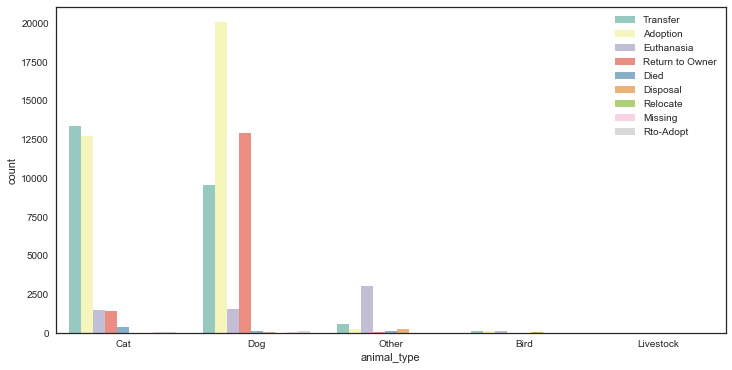

In [68]:
plt.figure(figsize=(12,6))
sns.countplot(data=raw_data,
              x='animal_type',
              hue='outcome_type',
              palette='Set3')
plt.legend(loc='upper right')
plt.show()

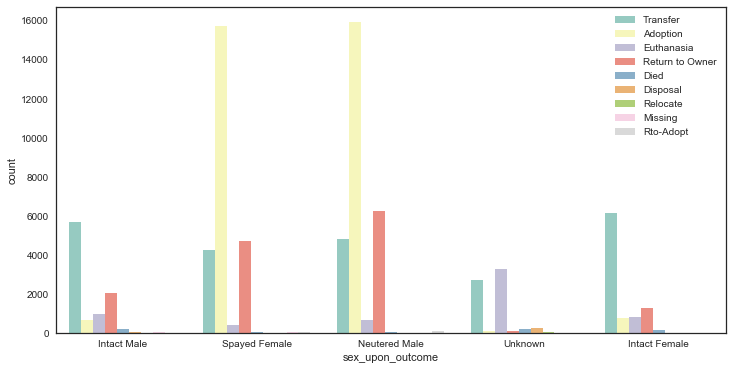

In [73]:
plt.figure(figsize=(12,6))
sns.countplot(data=raw_data,
              x='sex_upon_outcome',
              hue='outcome_type',
              palette='Set3')
plt.legend(loc='upper right')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


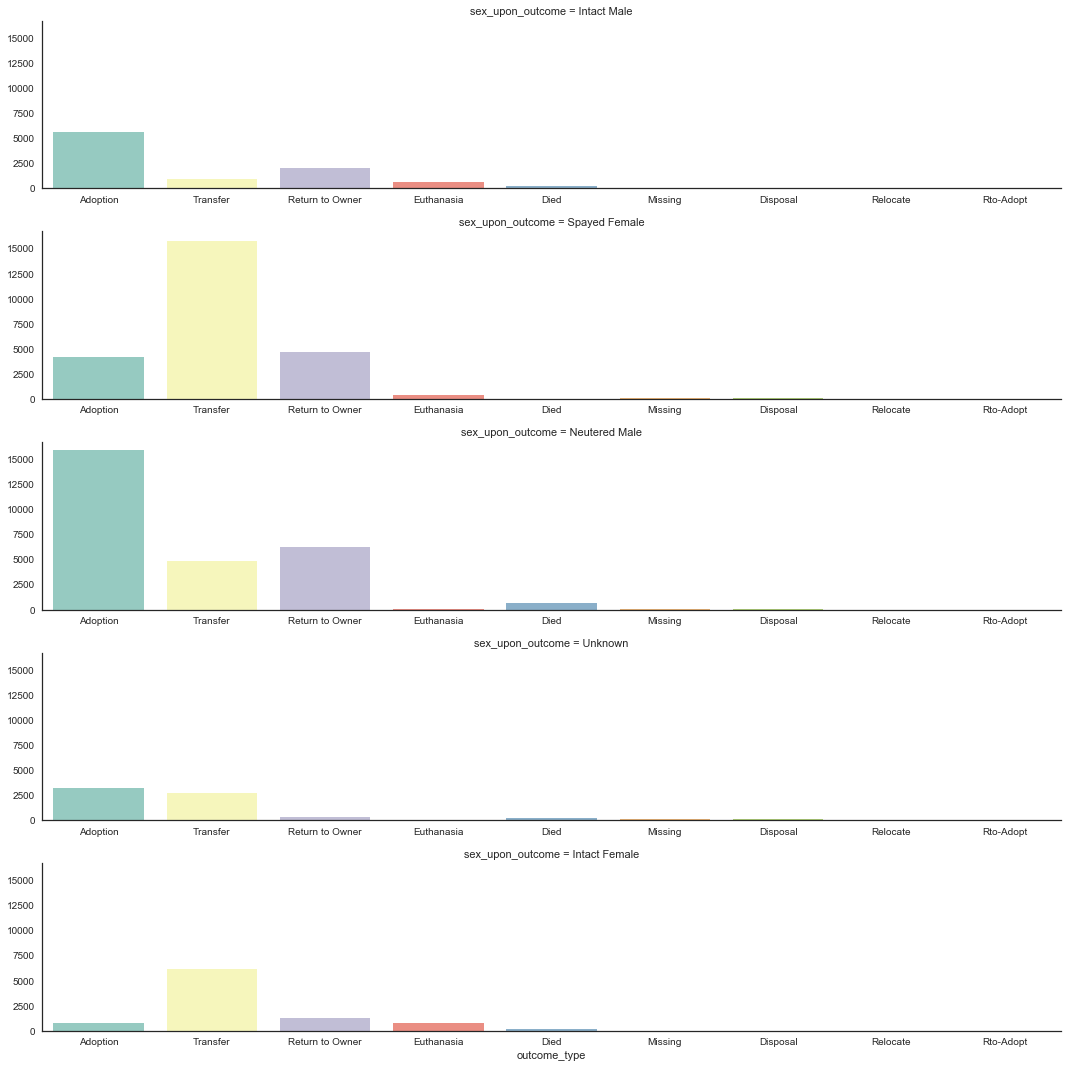

In [81]:
# plt.figure(figsize=(12,10))
# sns.countplot(y=data['sex_upon_outcome'], 
#                   palette='rainbow',
#                   hue=data['outcome_type'])
# plt.show()
#data['sex_upon_outcome'].value_counts()
g = sns.FacetGrid(raw_data, row="sex_upon_outcome", aspect=5)
g.map(sns.countplot, 'outcome_type', palette='Set3')
#x = data[['sex_upon_outcome', 'outcome_type']].groupby(by=['sex_upon_outcome', 'outcome_type']).head()
#x.value_counts()

Why does this graph look different than the one above it?